# One-Class SVMs: detección de anomalías

Hay dos maneras de detectar anomalías:

- De manera supervisada: se tienen suficientes instancias normales e instancias anormales del evento o entidad a analizar y por lo tanto se puede entrenar un modelo de clasificación.
- De manera no supervisada: solo se tienen instancias del evento o entidad a analizar, por lo que se debe analizar el patrón de lo que es común y de lo que no sería común.

Los modelos One-Class SVM pertenecen al segundo caso, identificando regiones del espacio de representación de las instancias que se consideran típicas de la categoría de interés, y por oposición regiones que serían atípicas para instancias de la misma.

Siguiendo con la idea de base de los SVMs, se define entonces una distribución de tipicidad de las instancias de la categoría. Para poder representar distribuciones de mayor riqueza, se utilizan kernels para proyectar los datos de entrenamiento a un espacio de mayor dimensionalidad, y para computar la similitud de cada nueva instancia a analizar con instancias que se encuentran en el límite de lo que se considera anormal sin tener que hacer un cambio explícito en la representación de los datos ("*kernel trick*").

Este taller está inspirado de un ejemplo de scikit-learn: https://scikit-learn.org/0.15/_downloads/plot_oneclass.py

## 1. Creación de datasets sintéticos aleatorios

Cargamos las librerías

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager
import seaborn as sns
from sklearn.svm import OneClassSVM

import warnings
warnings.filterwarnings('ignore')
#warnings.filterwarnings(action=‘ignore’,category=DeprecationWarning)
#warnings.filterwarnings(action=‘ignore’,category=FutureWarning)

Vamos a crear tres datasets aleatorios en un espacio de 2 dimensiones:

- dataset de entrenamiento: sobre el que se entrenará el modelo, utilizando un proceso generativo bimodal determinado
- dataset de test: se genera utilizando el mismo proceso generativo que el de entrenamiento
- dataset de outliers: siguiendo otro proceso generativo diferente al de los otros 2 datasets

El modelo aprendido con el primer dataset se aplicará a los otros 2 datasets.

Primero generamos 100 puntos de 2 dimensiones aleatoiramente siguiendo una distribucipon normal estándar:

In [2]:
np.random.seed(17)
X = 0.3* np.random.randn(100, 2)
print(X.shape)
X[0:3]

(100, 2)


array([[ 0.08287977, -0.55638842],
       [ 0.18717033,  0.34359339],
       [ 0.31115714,  0.56599168]])

Los datos originales aleatorios no los vamos a conservar.
Con el método **numpy.r_** podemos aumentarlos, definiendo copias trasladadas del mismo.
En el dataset de entrenamiento tendremos 2 copias del dataset anterior, una primera con 2 unidades restadas, otra segunda con 2 unidades adicionadas.

In [3]:
X_train = np.r_[X+2, X-2]
X_train[0:3]

array([[2.08287977, 1.44361158],
       [2.18717033, 2.34359339],
       [2.31115714, 2.56599168]])

Repetimos el proceso para crear el set de test con 20 instancias.

In [4]:
X = 0.3*np.random.randn(20, 2)
X_test = np.r_[X + 2, X - 2]

El dataset de outliers lo creamos siguiendo una distribución diferente (uniforme), con valores que caen en el mismo rango de valores que los datasets de entrenamiento y de test.

In [5]:
X_outliers = np.random.uniform(low=-4, high=4, size=(20, 2))

Ploteamos los datos 

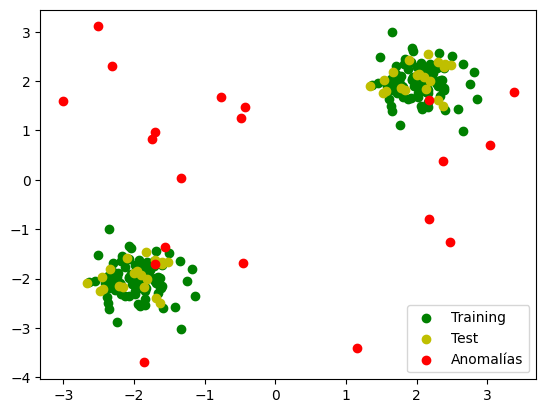

In [6]:
plt.scatter([a[0] for a in X_train],[a[1] for a in X_train], c="g", label="Training")
plt.scatter([a[0] for a in X_test],[a[1] for a in X_test], c="y", label="Test")
plt.scatter([a[0] for a in X_outliers],[a[1] for a in X_outliers], c="r", label="Anomalías")
plt.legend()
plt.show()

Vemos que en efecto los puntos de entrenamiento y de test siguen una distribución similar, bien diferente a la de los puntos anómalos. Sin embargo, esto no previene que no vayamos a confundir algunas de las anomalías como puntos normales 

## 2. Entrenamiento de modelo One-Class SVM

Vamos a utilizar la clase **OneClassSVM**, del paquete scikit-learn.
Para la instanciación, hay que especificar los mismos parámetros que con un clasificador o un regresor, aunque no hay que indicar el valor de *C*, pues no tiene sentido hablar de error de instancia en este caso. Nos interesan particularmente:

- *kernel*: el tipo de kernel a utilizar ('rbf' por defecto); otros valores aceptados son: ‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’. El kernel con más sentido desde el punto de vista de detección de anomalías es el rbf.
- *degree*: grado del polinomio en el caso del kernel 'poly' (3 por defecto); se ignora para otros kernels.
- *gamma*: determina la dispersión alrededor de los vectores de soporte ('auto' por defecto); solo se considera para los kernels ‘rbf’, ‘poly’ y ‘sigmoid’. Por defecto, *gamma* es igual a 1/m, donde m es el número de dimensiones. A mayor *gamma*, más complejo será el espacio de representación de los datos.

Se tiene además el siguiente parámetro, específico del One-Class SVM:

- *nu*: máxima la proporción de anomalías en el set de entrenamiento, tal que $0<nu\leq 1$ (por defecto 0.5, por lo que, a lo sumo, la mitad de los puntos de entrenamiento podrán considerarse outliers).

In [7]:
clf = OneClassSVM()
clf.fit(X_train)

OneClassSVM()

Definimos una función que nos permitirá analizar cómo queda la representación de la frontera de decisión que define el límite entre los puntos comúnes y los outliers.

In [8]:
def plot_oneclass_svm(svm):
    # Definimos una grilla de puntos sobre la cual vamos a determinar la frontera de detección de anomalías:
    xx, yy = np.meshgrid(np.linspace(-5, 5, 500), np.linspace(-5, 5, 500))

    # Obtenemos la distancia con la frontera de decisión para cada punto
    Z = svm.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.title("Fronteras de detección de anomalías (en rojo)")
    
    # Ploteamos fronteras y pintamos regiones interna y externa a la frontera
    plt.contourf(xx, yy, Z, levels=[Z.min(), 0], colors="gray") # Región anómala
    a = plt.contour(xx, yy, Z, levels=[0], linewidths=4, colors='red') # Fronteras de decisión
    plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors='palevioletred') # Región de tipicidad
    
    # Ploteamos los puntos de entrenamiento, test y anomalías
    s = 40
    b1 = plt.scatter(X_train[:, 0], X_train[:, 1], s=s, edgecolors='k', c="g") # Puntos de entrenamiento
    b2 = plt.scatter(X_test[:, 0], X_test[:, 1], s=s, edgecolors='k', c="y") # Puntos de Test
    c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], s=s, edgecolors='k', c="r") # Puntos excepcionales
    
    #Leyenda
    plt.axis('tight') # Solo el espacio necesario
    plt.xlim((-5, 5))
    plt.ylim((-5, 5))
    plt.legend([a.collections[0], b1, b2, c],
               ["Frontera de anomalías", "Training", "Test normales", "Test anómalos"],
               loc="upper left",
               prop=matplotlib.font_manager.FontProperties(size=11))
    plt.show()
    
    # Calculamos accuracy del training, test positivos y negativos
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)
    y_pred_outliers = clf.predict(X_outliers)
    n_error_train = y_pred_train[y_pred_train == -1].size
    n_error_test = y_pred_test[y_pred_test == -1].size
    n_error_outliers = y_pred_outliers[y_pred_outliers == 1].size
    
    print("Accuracy del training set: "+str(1-n_error_train/len(X_train)))
    print("Recall (normales) del test set: "+str(1-n_error_test/len(X_test)))
    print("Especificidad (anomalías) del test set: "+str(1-n_error_outliers/len(X_outliers)))
    print("Accuracy del test set entero: "+ str(1-(n_error_test+n_error_outliers)/(len(X_test)+len(X_outliers))))

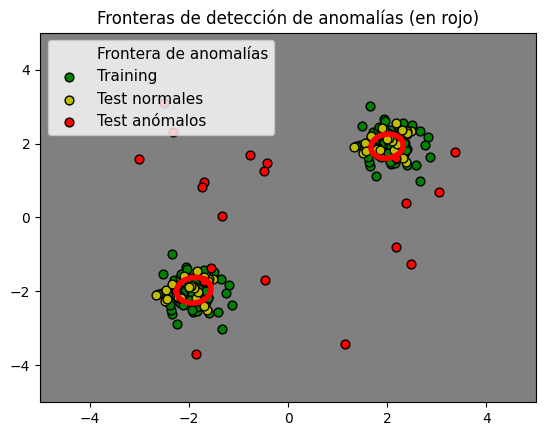

Accuracy del training set: 0.5
Recall (normales) del test set: 0.35
Especificidad (anomalías) del test set: 0.95
Accuracy del test set entero: 0.55


In [9]:
plot_oneclass_svm(clf)

Como podemos ver en el plot, y en la baja *accuracy*, la región de tipicidad de las instancias es demasiado conservadora, ya que permitimos que la mitad de los datos de entrenamiento sean considerados como outliers. Vamos a reducir *nu*, para aumentar la región de tipicidad.

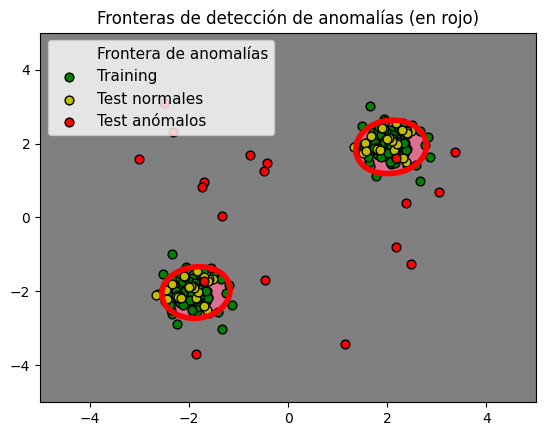

Accuracy del training set: 0.905
Recall (normales) del test set: 0.95
Especificidad (anomalías) del test set: 0.9
Accuracy del test set entero: 0.9333333333333333


In [10]:
clf = OneClassSVM(nu=0.1)
clf.fit(X_train)
plot_oneclass_svm(clf)

Podemos ver cómo las areas de tipicidad aumentan y la exactitud de la detección de outliers aumenta considerablemente.

Vamos a cambiar ahora el valor de *gamma*, aumentándo la flexibilidad de las fronteras de detección de las anomalías.

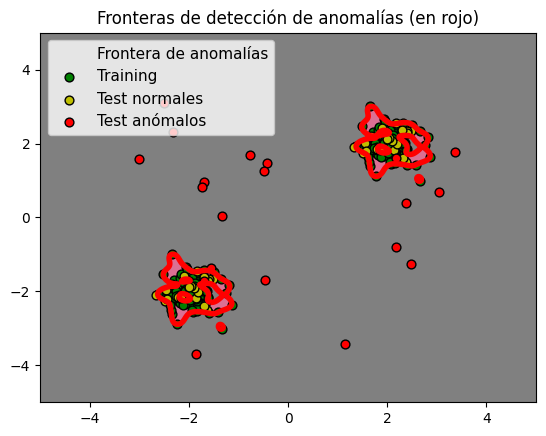

Accuracy del training set: 0.87
Recall (normales) del test set: 0.8
Especificidad (anomalías) del test set: 0.9
Accuracy del test set entero: 0.8333333333333334


In [11]:
clf = OneClassSVM(nu=0.1,gamma=10)
clf.fit(X_train)
plot_oneclass_svm(clf)

Aquí vemos demasiada complejidad, con un modelo con un claro overfitting, por lo que la exactitud baja con repecto a la configuración anterior.

Si por el contrario reducimos el gamma a 0.0001, vamos a tener el efecto contrario.

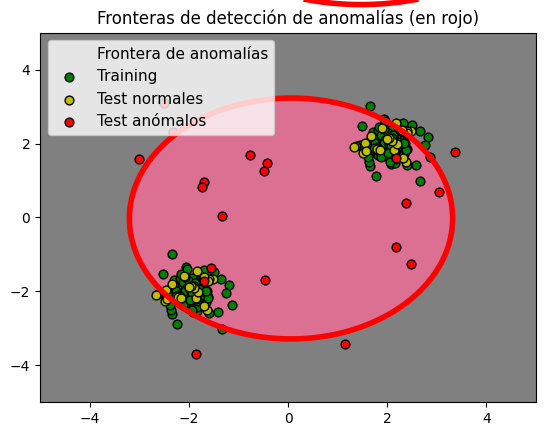

Accuracy del training set: 0.925
Recall (normales) del test set: 0.8
Especificidad (anomalías) del test set: 0.30000000000000004
Accuracy del test set entero: 0.6333333333333333


In [12]:
clf = OneClassSVM(nu=0.1,gamma=0.0001)
clf.fit(X_train)
plot_oneclass_svm(clf)

Ahora la frontera se simplificó demasiado, dañanado por completo el modelo.

Intentemos finalmente con kernel polinomial de grado 2 y de grado 20:

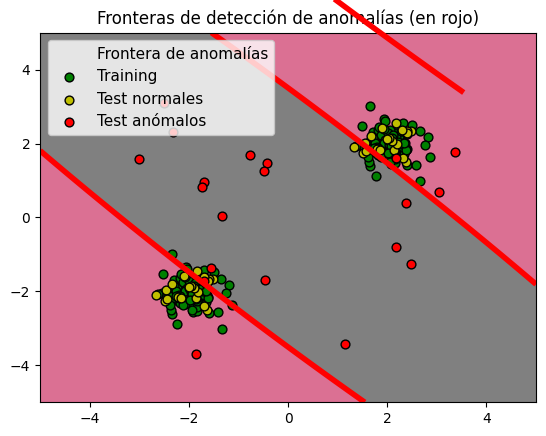

Accuracy del training set: 0.895
Recall (normales) del test set: 0.8
Especificidad (anomalías) del test set: 0.8
Accuracy del test set entero: 0.8


In [13]:
clf = OneClassSVM(kernel="poly", degree=2,nu=0.1)
clf.fit(X_train)
plot_oneclass_svm(clf)

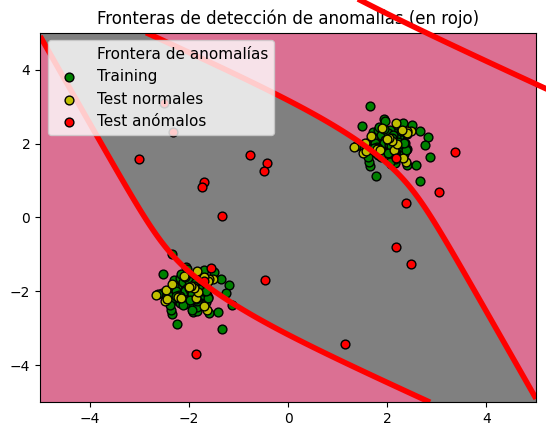

Accuracy del training set: 0.895
Recall (normales) del test set: 0.8
Especificidad (anomalías) del test set: 0.8
Accuracy del test set entero: 0.8


In [14]:
clf = OneClassSVM(kernel="poly", degree=20,nu=0.1)
clf.fit(X_train)
plot_oneclass_svm(clf)